# Alcohol's Impact on Life Expectancy
By: Jenna Hunte & Harriet Symington
# Introduction
In this tutorial you will analyze data about each country's life expectancy and alcohol consumption. You will try to determine if alcohol has an impact on average life expectancy. Additionally, you will break the data down by region and income to identify any other trends.

### Table of Contents
[Import Libraries](#libraries)<br>
[Data Collection](#collection)<br>
[Data Tidying](#tidying)<br>
[Exploratory Analysis and Data Visualization](#vis)<br>
[Hypothesis Testing](#test)<br>
[Other Hypotheses](#other)<br>
[Conclusion](#concl)<br>

## Import Libraries
<a id='libraries'><a\>

The following libraries will be needed throughout the tutorial, so before we begin we must import them. You may need to install a few libraries such as pycountry and plotly, which can be done by running pip install libraryname in terminal.

In [119]:
from countrycode import countrycode
import pycountry
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

## Data Collection
<a id='collection'><a\>

Now we are ready to begin. The first step in our analysis is to gather data and import it into our notebook.
You will need to download two seperate datasets - both of which are available from the following link: 
    https://data.world/jonloyens/alcohol-and-life-expectancy

The two datasets we will utilize are drinks.csv, which contains data on alcohol consumption around the world, and lifeexpectancy-verbose.csv, which contains data on LifeExpectancy dated from the World Health Organization.

In [120]:
drinks_df = pd.read_csv('drinks.csv')
drinks_df.head()

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol
0,Afghanistan,0,0,0,0.0
1,Albania,89,132,54,4.9
2,Algeria,25,0,14,0.7
3,Andorra,245,138,312,12.4
4,Angola,217,57,45,5.9


In [121]:
life_exp_df = pd.read_csv('lifeexpectancy-verbose.csv')
life_exp_df.head()

,GhoCode,GhoDisplay,PublishStateCode,PublishStateDisplay,YearCode,YearDisplay,RegionCode,RegionDisplay,WorldBankIncomeGroupGroupCode,WorldBankIncomeGroupDisplay,CountryCode,CountryDisplay,SexCode,SexDisplay,DisplayValue,Numeric
0,WHOSIS_000001,Life expectancy at birth (years),PUBLISHED,Published,1990,1990,AMR,Americas,WB_LMI,Lower_middle_income,NIC,Nicaragua,MLE,Male,68,68.0
1,WHOSIS_000002,Healthy life expectancy (HALE) at birth (years),PUBLISHED,Published,2012,2012,EUR,Europe,WB_HI,High_income,IRL,Ireland,MLE,Male,69,69.3
2,WHOSIS_000001,Life expectancy at birth (years),PUBLISHED,Published,2000,2000,EMR,Eastern Mediterranean,WB_LI,Low_income,YEM,Yemen,BTSX,Both sexes,61,61.0
3,WHOSIS_000001,Life expectancy at birth (years),PUBLISHED,Published,2000,2000,AFR,Africa,WB_LMI,Lower_middle_income,NGA,Nigeria,FMLE,Female,48,48.0
4,WHOSIS_000015,Life expectancy at age 60 (years),PUBLISHED,Published,1990,1990,SEAR,South_East Asia,WB_LMI,Lower_middle_income,THA,Thailand,FMLE,Female,19,19.0


## Data Tidying
<a id='tidying'><a\>

Now that we have our datasets imported, there is some tidying that needs to be done.

First off, we want to eliminate superfluous data from our tables. The Life Expectancy data contains a wide range of attributes, but we are only really interested in several of them. Before we go any further we can go ahead and eliminate unnecessary columns from the dataframe.

In [122]:
life_exp_df = life_exp_df.dropna()
life_exp_df = life_exp_df.drop(['GhoCode','PublishStateCode','PublishStateDisplay','WorldBankIncomeGroupGroupCode','YearDisplay','SexCode', 'SexDisplay','DisplayValue'],axis=1)
life_exp_df.head()

,GhoDisplay,YearCode,RegionCode,RegionDisplay,WorldBankIncomeGroupDisplay,CountryCode,CountryDisplay,Numeric
0,Life expectancy at birth (years),1990,AMR,Americas,Lower_middle_income,NIC,Nicaragua,68.0
1,Healthy life expectancy (HALE) at birth (years),2012,EUR,Europe,High_income,IRL,Ireland,69.3
2,Life expectancy at birth (years),2000,EMR,Eastern Mediterranean,Low_income,YEM,Yemen,61.0
3,Life expectancy at birth (years),2000,AFR,Africa,Lower_middle_income,NGA,Nigeria,48.0
4,Life expectancy at age 60 (years),1990,SEAR,South_East Asia,Lower_middle_income,THA,Thailand,19.0


Next, if you look at the numeric estimates for life expectancy in this data, you will see that these estimates are either based either off of an estimate at birth or an estimate at age 60. The numeric value represents the expected years of life from the time of the estimate; meaning that the overall life expectancy of countries with estimates at age 60 is really 60 plus the numeric value listed.

In order to have standardized life expectancy measurements for all countries, we want to replace the existing values with the total life expectancy. We do this by iterating through the dataframe and adding 60 to any numeric values  that were estimated at the age of 60 rather than at birth.

In [123]:
life_exp_df['TotalLifeExp'] = '0.0'
for index, row in life_exp_df.iterrows():
    if row['GhoDisplay'] == 'Life expectancy at birth (years)' or row['GhoDisplay'] == 'Healthy life expectancy (HALE) at birth (years)':
        life_exp_df.at[index,'TotalLifeExp'] = float(row['Numeric'])
    elif row['GhoDisplay'] == 'Life expectancy at age 60 (years)':
        life_exp_df.at[index,'TotalLifeExp'] = float(row['Numeric']) + 60.0     

Finally, since the Alcohol Consumption data is dated from the year 2010, so we don't want to look at Life Expectancy data in years too far off from that. We will take data from years 2008-2013 and use the average estimates from across these years.

In [124]:
life_exp_df['TotalLifeExp'] = life_exp_df['TotalLifeExp'].apply(pd.to_numeric)

life_exp_df = life_exp_df[life_exp_df.YearCode > 2008]
life_exp_df= life_exp_df.groupby('CountryCode', as_index= False).agg({'CountryDisplay':lambda x:x.value_counts().index[0],'RegionCode': lambda x:x.value_counts().index[0], 'RegionDisplay': lambda x:x.value_counts().index[0],'WorldBankIncomeGroupDisplay':lambda x:x.value_counts().index[0],'TotalLifeExp':'mean',})

life_exp_df = life_exp_df.rename(columns={'TotalLifeExp': 'AverageLifeExp'})

life_exp_df.head()

,CountryCode,CountryDisplay,RegionCode,RegionDisplay,WorldBankIncomeGroupDisplay,AverageLifeExp
0,AFG,Afghanistan,EMR,Eastern Mediterranean,Low_income,58.625000
1,AGO,Angola,AFR,Africa,Lower_middle_income,53.750000
2,ALB,Albania,EUR,Europe,Lower_middle_income,70.633333
3,AND,Andorra,EUR,Europe,High_income,77.875000
4,ARE,United Arab Emirates,EMR,Eastern Mediterranean,High_income,72.391667


Now that our Life Expectancy data is clean and concise, we can begin to tidy up the Alcohol Consumption data. In the Alcohol Consumption data there are a handful of country codes that were not found. Without the country codes, the data will not be included in our visual displays, so we need to manually enter country codes for the missing countries. 

In [125]:
drinks_df['CountryCode'] = 'NaN'

missing = {'Antigua & Barbuda':'ATG', 'Bolivia':'BOL', 'Bosnia-Herzegovina':'BIH', 'Brunei':'BRN', \
           'Cote d\'Ivoire':'CIV', 'Czech Republic':'CZE', 'North Korea':'PRK', 'DR Congo':'COD', 'Iran':'IRN', \
           'Laos':'LAO', 'Micronesia':'FSM', 'South Korea':'KOR', 'Moldova':'MDA', 'St. Kitts & Nevis':'KNA', \
           'St. Lucia':'LCA', 'St. Vincent & the Grenadines':'VCT', 'Sao Tome & Principe':'STP', 'Syria':'SYR', \
           'Macedonia':'MKD', 'Trinidad & Tobago':'TTO', 'Tanzania':'TZA', 'USA':'USA', 'Venezuela':'VEN', \
           'Vietnam':'VNM'}

for index, row in drinks_df.iterrows():
    try:
        drinks_df.at[index,'CountryCode'] = pycountry.countries.get(name=row['country']).alpha_3
    except KeyError:
        drinks_df.at[index,'CountryCode'] = missing[row['country']]
        
drinks_df.head()

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol,CountryCode
0,Afghanistan,0,0,0,0.0,AFG
1,Albania,89,132,54,4.9,ALB
2,Algeria,25,0,14,0.7,DZA
3,Andorra,245,138,312,12.4,AND
4,Angola,217,57,45,5.9,AGO


Now that we have tidied our data, lets combine our two datasets.

In [126]:
df = life_exp_df.join(drinks_df.set_index('CountryCode'), on= 'CountryCode')
df = df.drop(['country'], axis=1)
df.head()

,CountryCode,CountryDisplay,RegionCode,RegionDisplay,WorldBankIncomeGroupDisplay,AverageLifeExp,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol
0,AFG,Afghanistan,EMR,Eastern Mediterranean,Low_income,58.625000,0.0,0.0,0.0,0.0
1,AGO,Angola,AFR,Africa,Lower_middle_income,53.750000,217.0,57.0,45.0,5.9
2,ALB,Albania,EUR,Europe,Lower_middle_income,70.633333,89.0,132.0,54.0,4.9
3,AND,Andorra,EUR,Europe,High_income,77.875000,245.0,138.0,312.0,12.4
4,ARE,United Arab Emirates,EMR,Eastern Mediterranean,High_income,72.391667,16.0,135.0,5.0,2.8


# Exploratory Analysis and Data Visualization
<a id='vis'><a\>

In this part of the tutorial, we will take our tidied data and transform it into several visual representations. We will look at different attributes to identify trends in the data. The first visualization is a color coded map that shows each country's alcohol consumption. The darker colors denote higher consumption where as the lighter colors denote lower consumption. Likewise, the second visualization shows each country's life expectancy where the darker colors denote higher life expectancy and the lighter colors denote lower life expectancy. 

From these visuals, we will be able to tell if there is an obvious trend between life expectancy and alcohol. If the color patterns are the same on both maps then we know there is a relationship. 

In [127]:
data_drinks = [ dict(
        type = 'choropleth',
        locations = df['CountryCode'],
        z = df['total_litres_of_pure_alcohol'],
        text = df['CountryDisplay'],
        colorscale = [[0,"rgb(102, 0, 0)"],[0.35,"rgb(204, 0, 0)"],[0.5,"rgb(255, 0, 0)"],\
            [0.6,"rgb(255, 102, 102)"],[0.7,"rgb(255, 153, 153)"],[1,"rgb(255, 204, 204)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            title = 'Total Liters of Pure Alcohol Per Capita'),
      ) ]

In [128]:
layout_drinks = dict(
    title = '2010 Global Alcohol Consumption Per Capita<br>Source:\
            <a https://data.world/jonloyens/alcohol-and-life-expectancy">\
            data.world</a>',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

To generate these maps you will need to make a free [plot.ly](https://plot.ly/) account. You will need to replace the username with your own username and generate your own unique key.  

In [129]:
plotly.tools.set_credentials_file(username='jhunte1', api_key='ZDsEMoByGL6bWYLHdlG4')

fig = dict(data=data_drinks, layout=layout_drinks )
plotly.plotly.iplot(fig, validate=False, filename='d3-world-map_drinks')

In [130]:
data_life = [ dict(
        type = 'choropleth',
        locations = df['CountryCode'],
        z = df['AverageLifeExp'],
        text = df['CountryDisplay'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            title = 'Life Expectancy<br>Years'),
      ) ]

In [131]:
layout_life = dict(
    title = '2010 Global Life Expectancy<br>Source:\
            <a https://data.world/jonloyens/alcohol-and-life-expectancy">\
            data.world</a>',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

In [132]:
fig = dict(data=data_life, layout=layout_life)
plotly.plotly.iplot(fig, validate=False, filename='d3-world-map')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~jhunte1/0 or inside your plot.ly account where it is named 'd3-world-map'


We will now create a scatter plot that shows each country's alcohol consumption in relation to their average life expectancy. A linear trend would show the two are correlated. 

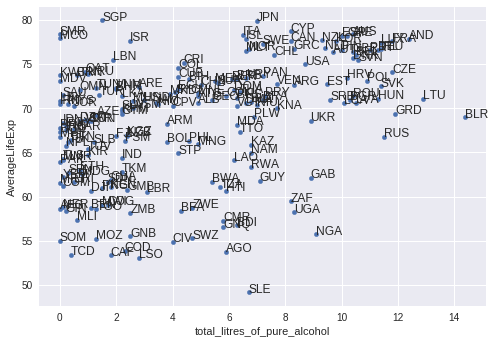

In [133]:
ax = df.plot(kind='scatter', x='total_litres_of_pure_alcohol', y='AverageLifeExp')
avg = df.groupby('CountryCode')['total_litres_of_pure_alcohol','AverageLifeExp'].mean()
for i, row in enumerate(avg.itertuples()):
    ax.annotate(row.Index, (row.total_litres_of_pure_alcohol, row.AverageLifeExp))
plt.show()

Based on our three representations, there is no clear trend between alcohol consumption and life expectancy. There are countries that have a high alcohol consumption and a high life expectancy, but there are also countries that have a high alcohol consumption and a low life expectancy. This holds true for low alcohol consumption too. 

Although our hypothesis does not appear to be true, we will look at the regression line to confirm our assumption.

# Hypothesis Testing
<a id='test'><a\>

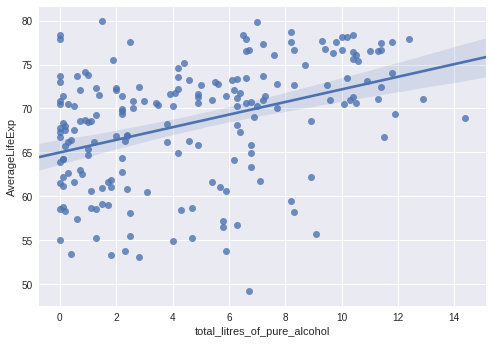

In [134]:
sns.regplot(x="total_litres_of_pure_alcohol", y="AverageLifeExp", data=df)
plt.show()

In [135]:
regression = smf.ols(formula='AverageLifeExp ~ total_litres_of_pure_alcohol', data=df).fit()
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         AverageLifeExp   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     35.57
Date:                Fri, 15 Dec 2017   Prob (F-statistic):           1.17e-08
Time:                        21:21:35   Log-Likelihood:                -627.60
No. Observations:                 193   AIC:                             1259.
Df Residuals:                     191   BIC:                             1266.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       65.0010      0.725     89.616      0.000      63.570      66.432
total_litres_of_pure_alcohol     0.7168      0.120      5.964      0.000       0.480       0.954
==============================================================================
Omnibus:                       12.660   Durbin-Watson:                   1.714
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.599
Skew:                          -0.648   Prob(JB):                      0.00111
Kurtosis:                       3.099   Cond. No.                         9.84
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [136]:
ftest = sm.stats.anova_lm(regression, typ=2)
print(ftest)

                                   sum_sq     df          F        PR(>F)
total_litres_of_pure_alcohol  1404.656065    1.0  35.566638  1.172346e-08
Residual                      7543.285534  191.0        NaN           NaN


The results of the regression model suggest that life expectancy actually increases with alcohol consumption. This seems unlikely, so we suspect that there is some other factor affecting these results. For example, it is possible that other attributes, such as region or income level, are affecting both life expectancy and alcohol use, which may give misleading results when examining the corelation strictly between life expectancy and alcohol consumption. 

# Other Hypotheses
<a id='other'><a\>


Since we could not show a strong correlation between alcohol consumption and average life expectancy, we will now break the data up by region and income to see if these factors reveal any trends. 

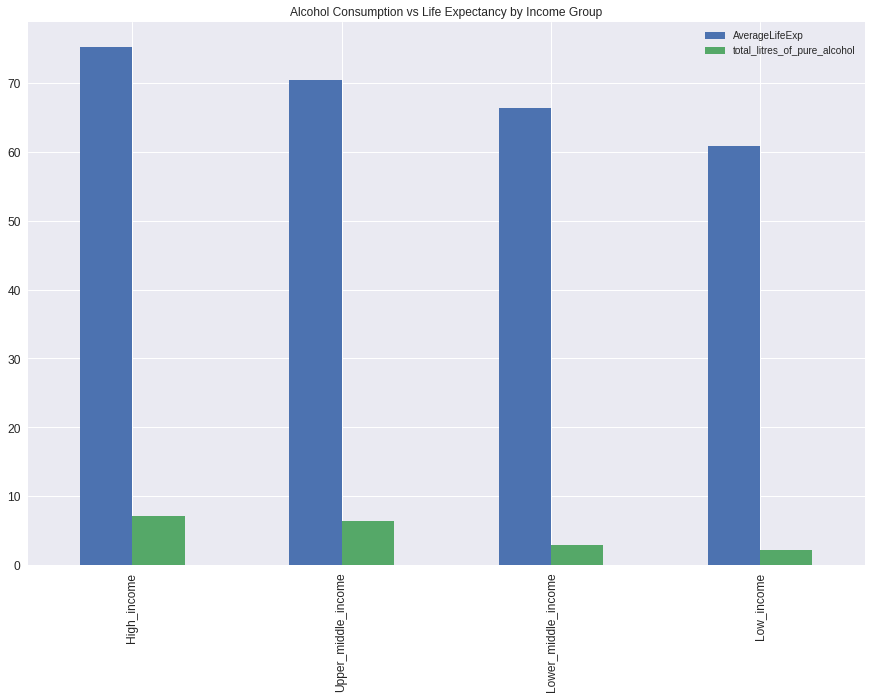

In [137]:
df_by_income = df.groupby('WorldBankIncomeGroupDisplay', as_index=False)['AverageLifeExp','total_litres_of_pure_alcohol'].mean()

df_by_income = df_by_income.reindex([0, 3, 2, 1])
ax = df_by_income.plot(kind='bar', title ="Alcohol Consumption vs Life Expectancy by Income Group", figsize=(15, 10), legend=True, fontsize=12)
ax.set_xticklabels(df_by_income['WorldBankIncomeGroupDisplay'])

plt.show()  

Ok, so income level clearly plays a huge role on both factors. As the income groups get wealthier, both the life expectancies and the level of alcohol consumed increases. It makes sense that lower income countries would have a lower overall life expectancy. Let's try only comparing alcohol consumption and life expectancy within the same income groups to see if we can identify any trends there, without income level affecting the results.

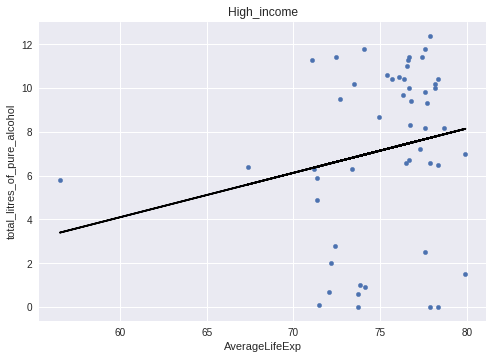

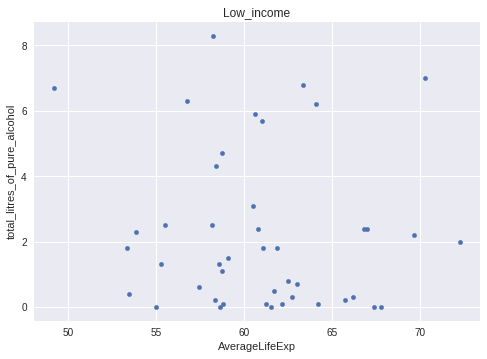

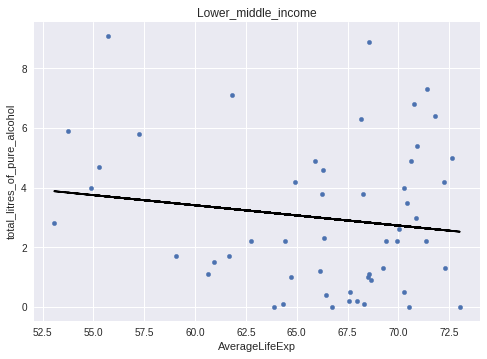

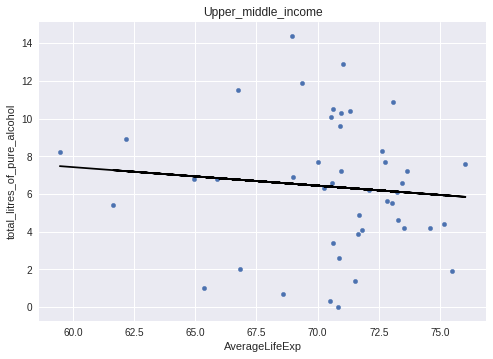

In [138]:
for key, grp in df.groupby('WorldBankIncomeGroupDisplay'):
    grp.plot(kind='scatter', x='AverageLifeExp', y='total_litres_of_pure_alcohol')
    plt.title(key)
    
    avg = df.groupby('CountryCode')['total_litres_of_pure_alcohol','AverageLifeExp'].mean()
    
    fit = np.polyfit(grp['AverageLifeExp'],grp['total_litres_of_pure_alcohol'],1) # add the regression line
    plt.plot(grp['AverageLifeExp'], fit[0] * grp['AverageLifeExp'] + fit[1], color = 'black')

plt.show()

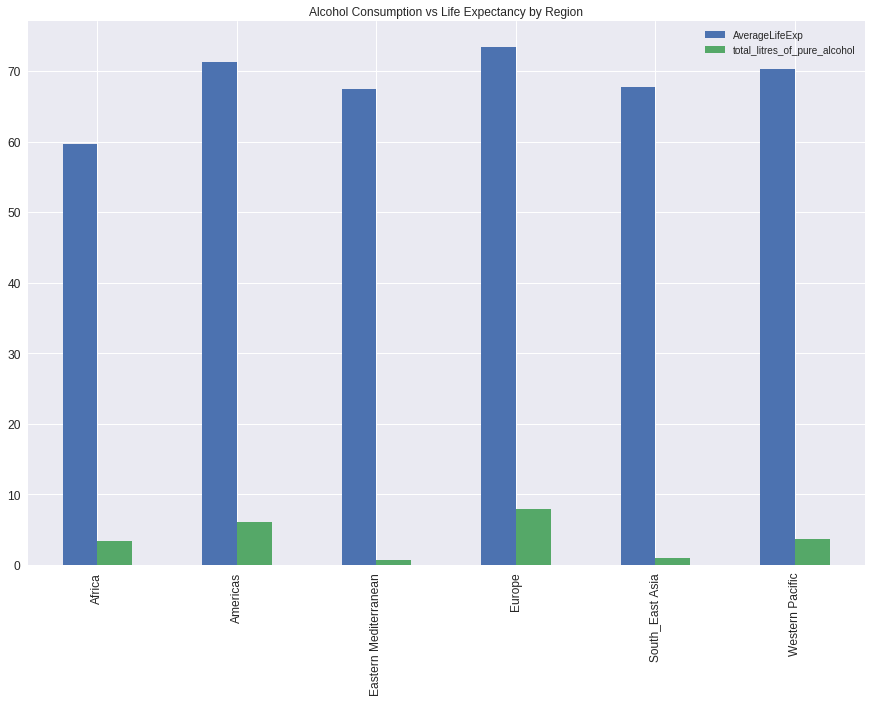

In [139]:
df_by_region = df.groupby('RegionDisplay', as_index=False)['AverageLifeExp','total_litres_of_pure_alcohol'].mean()

# df_by_region = df_by_income.reindex([0, 3, 2, 1])
ax = df_by_region.plot(kind='bar', title ="Alcohol Consumption vs Life Expectancy by Region", figsize=(15, 10), legend=True, fontsize=12)
ax.set_xticklabels(df_by_region['RegionDisplay'])

plt.show() 

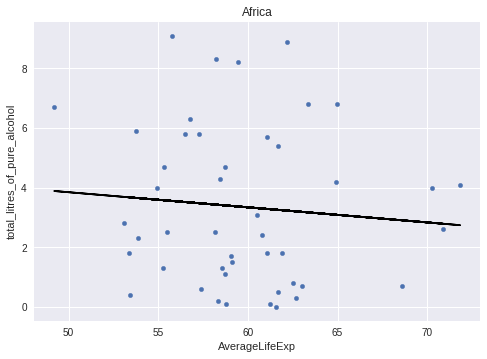

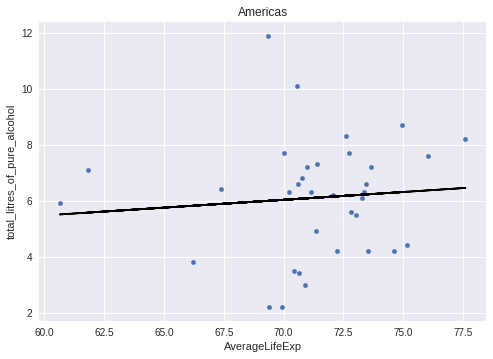

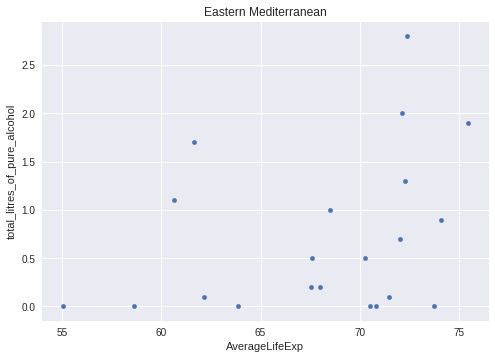

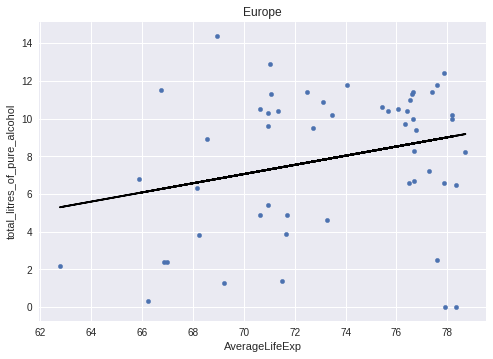

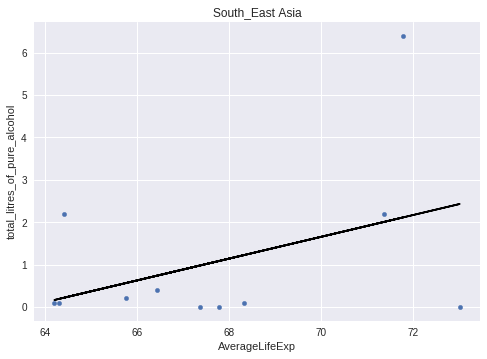

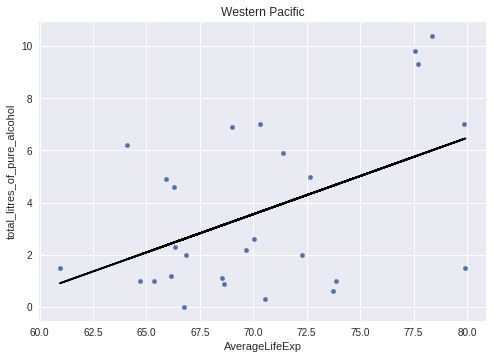

In [140]:
for key, grp in df.groupby('RegionDisplay'):
    grp.plot(kind='scatter', x='AverageLifeExp', y='total_litres_of_pure_alcohol')
    plt.title(key)
    
    avg = df.groupby('CountryCode')['total_litres_of_pure_alcohol','AverageLifeExp'].mean()
    
    fit = np.polyfit(grp['AverageLifeExp'],grp['total_litres_of_pure_alcohol'],1) # add the regression line
    plt.plot(grp['AverageLifeExp'], fit[0] * grp['AverageLifeExp'] + fit[1], color = 'black')

plt.show()

# Conclusion
<a id='concl'><a\>

Based on our analysis, we were unable to conclude that alcohol consumption is correlated to life expectancy. To support this conclusion, here is a [study](https://www.rwjf.org/en/culture-of-health/2013/08/alcohol_and_lifeexp.html) done by Patrick M. Krueger, PhD, that shows that there is little to no difference in not drinking and drinking. When the data was split into income groups, we could determine that higher income countries have a higher life expectancy and a higher alcohol consumption. This leads us to believe that the socioeconomic status of a country has a much larger impact on the life expectancy than the alcohol consumption. We can not conclusively determine this from our data, but further research my reveal this underlying cause. Here is a [medical research paper](https://www.ncbi.nlm.nih.gov/pubmed/2722920) detailing the impact socioeconomic status has on life expectancy. We also believe that alcohol consumption varies because of socioeconomic status and religious beliefs. In the areas that are predominantly Muslim, a religion that does not believe in alcohol consumption, we see much lower consumption per capita. This holds true for countries with a lower socioeconomic status. Here is an [article](https://pubs.niaaa.nih.gov/publications/arh27-1/95-109.htm) that compares international alcohol consumption and can explain why we see these differences between each country. Our data may lead us to conclude that consuming more alcohol makes you live longer, but we believe the socioeconomic status is responsible for this trend and that alcohol does not have a large enough effect to impact a country's life expectancy. More developed countries have greater access to alcohol and more resources to purchase it.